In [48]:
# all the import statements

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [ ]:
def load_data():
    train_data = pd.read_csv('train.csv')
    return train_data

train_data = load_data()
training_data = train_data.drop(columns=["Transported"])
target_label = train_data["Transported"]
target_label = target_label.astype(int)  # Convert boolean to int8 for memory efficiency
target_attributes = ["Transported"]

num_attributes = training_data.select_dtypes(include=[np.number]).columns.tolist()
cat_attributes = training_data.select_dtypes(exclude=[np.number]).columns.tolist()
items_to_remove = ["PassengerId", "Name", "Cabin","CryoSleep","VIP"]
new_cat_attributes = [ x for x in cat_attributes if x not in items_to_remove]
bool_attributes = ["CryoSleep", "VIP"]

# scat_matrix = scatter_matrix(training_data,figsize=(10,10),grid=True, diagonal='kde', alpha=0.2)
# training_data.hist(figsize=(10,10), grid=True, bins=20, alpha=0.5)
print("Basic processing completed.")

In [50]:
training_data = shuffle(training_data, random_state=42)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('select_k_best', SelectKBest(k=10))  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

bool_pipeline = Pipeline([  
    ('imputer', SimpleImputer(strategy='constant', fill_value=False)),])

pre_processing = ColumnTransformer(
    transformers=[
        ('num', num_pipeline,num_attributes),
        ('cat', cat_pipeline,new_cat_attributes),
        ('bool', bool_pipeline,bool_attributes)
    ]
)

In [51]:
def compute_class_weights(train_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Transported"]),y=train_data["Transported"])
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")
    return class_weight_dict

class_weights = compute_class_weights(train_data)

Class weights computed


In [52]:
sgd_clf = SGDClassifier(random_state=42,loss="hinge",penalty="l2",max_iter=1000, tol=1e-3,
                        alpha=0.00001, learning_rate="optimal", eta0=0.0, power_t=0.5,
                        early_stopping=True,class_weight=class_weights)

svm_clf = SVC(kernel="rbf", C=1.0, gamma='scale', probability=True,random_state=42)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10,
                                min_samples_split=10, min_samples_leaf=2,
                                max_features='log2', bootstrap=True,ccp_alpha=0.01,
                                class_weight=class_weights, random_state=42)

model_pipeline = Pipeline([
('pre_processor', pre_processing),
('classifier', rf_clf)])

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cvl_scores = cross_validate(model_pipeline, training_data, target_label, cv=5,scoring=scoring,
                            error_score="raise")
cvl_scores_df = pd.DataFrame(cvl_scores)
print(pd.DataFrame(cvl_scores_df.mean()))   

Model pipeline created.


[[0.50018731 0.49981269]
 [0.50018731 0.49981269]
 [0.50018731 0.49981269]
 ...
 [0.50008256 0.49991744]
 [0.50008256 0.49991744]
 [0.50008256 0.49991744]]


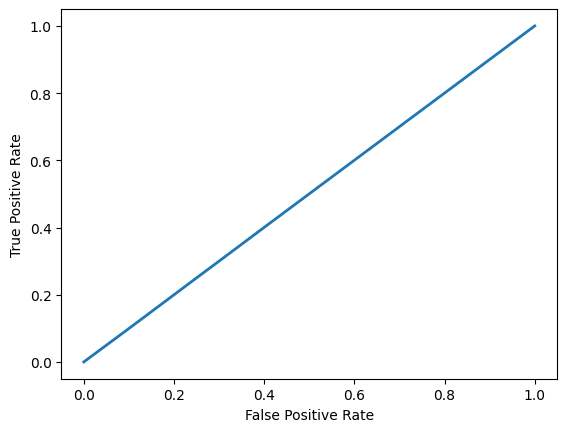

Model training and evaluation completed.


In [54]:
from sklearn.model_selection import cross_val_predict

prd_scores = cross_val_predict(model_pipeline, training_data ,target_label, cv=20,method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(target_label, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [55]:
from sklearn.model_selection import RandomizedSearchCV

param_dict = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': [0.0, 0.01, 0.1],
    'classifier__bootstrap': [True, False]
}
# Perform RandomizedSearchCV with SVC-specific parameters
random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(training_data, target_label)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__ccp_alpha': 0.0, 'classifier__bootstrap': False} 0.508224969576976
random_search completed.
